In [32]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorcircuit as tc
from scipy.linalg import expm

K=tc.set_backend("tensorflow")

def expectation_of_matrix(a0,a1,theta):
    v_0=np.array([[1],[0]])
    if a0==0:
        P=np.array([[1,0],[0,1]])
    elif a0==1:
        P=np.array([[0,1],[1,0]])
    elif a0==2:
        P=np.array([[0,-1j],[1j,0]])
    elif a0==3:
        P=np.array([[1,0],[0,-1]])
    if a1==0:
        Q=np.array([[1,0],[0,1]])
    elif a1==1:
        Q=np.array([[0,1],[1,0]])
    elif a1==2:
        Q=np.array([[0,-1j],[1j,0]])
    elif a1==3:
        Q=np.array([[1,0],[0,-1]])
    v_theta=np.matmul(expm(0.5*1j*theta*P),v_0)
    intermediate=np.matmul(Q,v_theta)
    return np.matmul(np.transpose(v_theta).conj(),intermediate)

def differential_z_1(f,x,y,z):
    delta=np.pi/6
    diff1=f(x,y,z+delta)-f(x,y,z-delta)
    return diff1


def found_min_f(step,x_0,f):
    f_min=f(1,2,x_0)
    diff=differential_z_1(f,1,2,x_0)
    while abs(diff)>=0.001:
        f_temp=f(1,2,x_0-step*diff)
        if f_temp<f_min:
            x_0=x_0-step*diff
            f_min=f_temp
        else:
            step=step/2
        diff=differential_z_1(f,1,2,x_0)
    return f_min,x_0
f_min,x_0=found_min_f(0.1,0.25*np.pi,expectation_of_matrix)
print(f_min,x_0)

tc.set_dtype("complex128")

def expectation_of_matrix_1(a0,a1,theta):
    v_0=np.array([[1],[0]])
    if a0==0:
        P=np.array([[1,0],[0,1]])
    elif a0==1:
        P=np.array([[0,1],[1,0]])
    elif a0==2:
        P=np.array([[0,-1j],[1j,0]])
    elif a0==3:
        P=np.array([[1,0],[0,-1]])
    P=tc.array_to_tensor(P)
    if a1==0:
        Q=np.array([[1,0],[0,1]])
    elif a1==1:
        Q=np.array([[0,1],[1,0]])
    elif a1==2:
        Q=np.array([[0,-1j],[1j,0]])
    elif a1==3:
        Q=np.array([[1,0],[0,-1]])
    Q=tc.array_to_tensor(Q)
    v_theta=tc.backend.expm(0.5*1j*theta*P)@v_0
    intermediate=Q@v_theta
    return K.real((K.transpose(K.conj(v_theta))@intermediate)[0][0])

def found_min_f_1(step,x_0,f):
    f_min=f(1,2,x_0)
    diff=K.grad(f,argnums=2)(1,2,x_0)
    while abs(diff)>=1e-3:
        f_temp=f(1,2,x_0-step*diff)
        if f_temp<f_min:
            x_0=x_0-step*diff
            f_min=f_temp
        else:
            step=step/2
        diff=K.grad(f,argnums=2)(1,2,x_0)
    return f_min,x_0
    
f_min,x_0=found_min_f_1(0.1,tc.array_to_tensor(0.25*np.pi),expectation_of_matrix_1)
print(f_min,x_0)

[[-0.99999955+0.j]] [[-1.56984791+0.j]]
tf.Tensor(-0.9999995502491636, shape=(), dtype=float64) tf.Tensor((-1.5698479061394408+0j), shape=(), dtype=complex128)


In [33]:
def n_qbit_circuit1(n):
    c=tc.Circuit(n)
    c.h(0)
    for i in range(1,n):
        c.cnot(0,i)
    print(c.state())
    print(c.draw())
def n_qbit_circuit2(n):
    c=tc.Circuit(n)
    for i in range(n):
        c.h(i)
    print(c.state())
    print(c.draw())
n_qbit_circuit1(2)
n_qbit_circuit2(2)
def given_transpose():
    c=tc.Circuit(3)
    c.ANY(0,unitary=tc.array_to_tensor([[0,1],[1,0]]),name="U1")
    c.ANY(1,unitary=tc.array_to_tensor([[1,0],[0,-1]]),name="U2")
    c.cswap(2,0,1)
    print(c.state())
    print(c.draw())
given_transpose()

tf.Tensor([0.70710677+0.j 0.        +0.j 0.        +0.j 0.70710677+0.j], shape=(4,), dtype=complex128)
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
tf.Tensor([0.49999998+0.j 0.49999998+0.j 0.49999998+0.j 0.49999998+0.j], shape=(4,), dtype=complex128)
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘
tf.Tensor([0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j], shape=(8,), dtype=complex128)
     ┌────┐   
q_0: ┤ U1 ├─X─
     ├────┤ │ 
q_1: ┤ U2 ├─X─
     └────┘ │ 
q_2: ───────■─
              


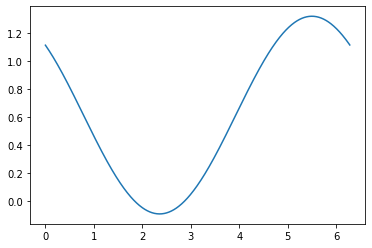

tf.Tensor(
[[-0.35355338 -0.6123724 ]
 [-0.70710677 -0.70710677]], shape=(2, 2), dtype=float32)
tf.Tensor(-0.707106747077096, shape=(), dtype=float64)


In [34]:
def exp_sumz(n,nlayers,param):
    c=tc.Circuit(n)
    for j in range(nlayers):
        for i in range(n):
            c.rx(i,theta=param[i][j])
        for i in range(n-1):
            c.cnot(i,i+1)
    return K.real(K.sum([c.expectation_ps(z=[i]) for i in range(n)]))
X=np.arange(0,2*np.pi,0.01)
plt.plot(X,[exp_sumz(2,2,[[np.pi/6,np.pi/4],[np.pi/4,x]]) for x in X])
plt.show()
print(K.grad(exp_sumz, argnums=2)(2,2,K.convert_to_tensor([[np.pi/6,np.pi/4],[np.pi/4,np.pi/4]])))

print(exp_sumz(2,2,[[np.pi/6,np.pi/4],[np.pi/4,np.pi/4+np.pi/6]])-
      exp_sumz(2,2,[[np.pi/6,np.pi/4],[np.pi/4,np.pi/4-np.pi/6]]))